<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
import pandas as pd
import scipy as sp
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import stats
from datetime import timedelta, datetime
import sympy as smp
from IPython.display import display, Math

# My own functions
import import_ipynb
import Functions

plt.ioff()
smp.init_printing()

importing Jupyter notebook from Functions.ipynb


In [3]:
dates = ['jan_28_2019', 'jan_30_2019', 'jan_31_2019', 'feb_1_2019',
         'feb_4_2019', 'feb_5_2019', 'feb_7_2019', 'feb_8_2019']

# Open DataFrames

In [4]:
upper_int = 100000
lower_int = 0

mode_std = 0.015

## Pulse Data

In [5]:
dfs = []
paths = ['datafiles/'+date for date in dates]
for path in paths:
    for filename in os.listdir(path):
        if filename.endswith(".csv"):
            df = pd.read_csv(path+'/'+filename, sep=',', index_col=0).astype(float)
            df['ratio']=(df['Integral 1200']-df['Integral 0'])/(df['Integral 7400']-df['Integral 0'])
            df.index = pd.to_datetime(df.index,unit='s')-timedelta(hours=7)
        
            df = df[(df['ratio']<1) & (df['ratio']>0)] #should not have to do this
            df = df[(df['Integral 7400']<upper_int) & (df['Integral 7400']>lower_int)] #should not have to do this
            dfs.append(df)

dfs = sorted(dfs,key=lambda x:x.index[0]) #sort by initial time

## Temperature Data

In [6]:
temps = []
for path in paths:
    for filename in os.listdir(path):
        if filename.endswith(".txt"):
            temp = pd.read_csv(path+'/'+filename, skiprows=7, sep='\t')
            temp['Time'] = pd.to_datetime(temp['DATE']+'-'+temp['TIME'])
            temp.index = temp['Time']
            temp = temp[['TEMPERATURE', 'RELATIVE-HUMIDITY', 'DEW-POINT']]
            temps.append(temp)
temps = sorted(temps,key=lambda x:x.index[0]) #sort by initial time

# Temperature Stuff

## Find Mean and STD Temperature During each of the Red Bars

In [7]:
all_temps = pd.concat(temps)

Get the data and the errors. This uses the compute_datapoint function defined in the Functions notebook which takes in a dataframe and all the temperatures, and computes temperature values, ratio values, temperature errors, and ratio errors.

## Ratios

In [8]:
data = [Functions.compute_datapoint(df, all_temps, mode_std) for df in dfs]

temps = np.array([data[i][0][0] for i in range(len(data))])
ratios = np.array([data[i][0][1] for i in range(len(data))])
temps_err =np.array([data[i][1][0] for i in range(len(data))])
ratios_err =np.array([data[i][1][1] for i in range(len(data))])

lin_minmax = np.array([min(temps), max(temps)])

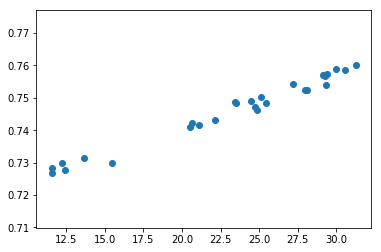

In [9]:
plt.scatter(temps, ratios)

## Total Energys

In [10]:
data = [Functions.compute_datapoint_energy(df, all_temps, mode_std = 1500) for df in dfs]

tmps = np.array([data[i][0][0] for i in range(len(data))])
energys = np.array([data[i][0][1] for i in range(len(data))])
tmps_err =np.array([data[i][1][0] for i in range(len(data))])
energys_err =np.array([data[i][1][1] for i in range(len(data))])

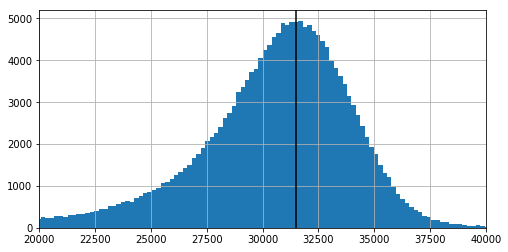

In [12]:
i = 21
fig, ax = plt.subplots(1, 1, figsize=(8,4))

dfs[i]['Integral 7400'].hist(bins=500)

ax.set_xlim(20000, 40000)
ax.axvline(energys[i], color='k')


Do a linear fit on the data, with errors at 95% confidence

In [13]:
def func(x, a, b):
    return a+b*x

[a, b], pcov = curve_fit(func, temps, ratios)
perr = np.sqrt(np.diag(pcov))
[del_a, del_b] = sp.stats.t.ppf(1-0.05/2, len(temps)-2)*perr

lin_fit = a+b*lin_minmax
lin_fit_upr = (a-del_a)+(b+del_b)*lin_minmax
lin_fit_lwr = (a+del_a)+(b-del_b)*lin_minmax

Sample final plot...

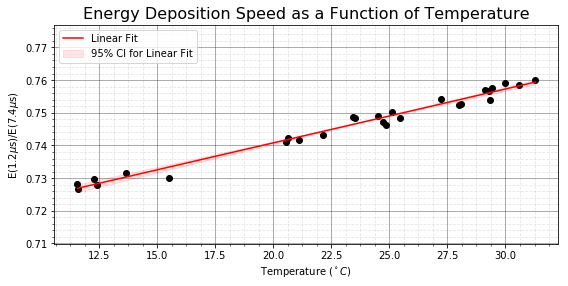

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

#Data
plt_d = ax.scatter(temps, ratios, color='k', label='Data Points')
#plt_de = ax.errorbar(temps, ratios, xerr=temps_err, yerr=ratios_err, linestyle='', alpha=0.4, label='Standard Error')

#Fitting
plt_lf, = ax.plot(lin_minmax, lin_fit, color='r', label='Linear Fit')
plt_lfe = ax.fill_between(lin_minmax, lin_fit_lwr, lin_fit_upr, color='r', alpha=0.1, label='95% CI for Linear Fit')

ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('E(1.2$\mu$s)/E(7.4$\mu$s)')
ax.set_title('Energy Deposition Speed as a Function of Temperature', fontsize=16)

plt.minorticks_on()
ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.4)
ax.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.1)

#Legends
#first_legend = plt.legend(handles=[plt_d, plt_de], loc=1)
second_legend = plt.legend(handles=[plt_lf, plt_lfe], loc=2)
#ax = plt.gca().add_artist(first_legend)


fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('plots/sample_final_plot.png', dpi=600)
plt.show()

In [15]:
a

In [16]:
b

In [17]:
del_a

In [18]:
del_b

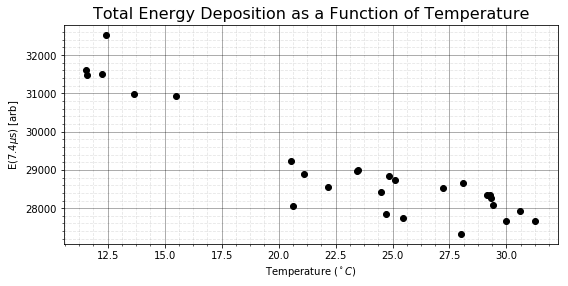

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

#Data
plt_d = ax.scatter(tmps, energys, color='k', label='Data Points')
#plt_de = ax.errorbar(temps, ratios, xerr=temps_err, yerr=ratios_err, linestyle='', alpha=0.4, label='Standard Error')

#Fitting
'''
plt_lf, = ax.plot(lin_minmax, lin_fit, color='r', label='Linear Fit')
plt_lfe = ax.fill_between(lin_minmax, lin_fit_lwr, lin_fit_upr, color='r', alpha=0.1, label='95% CI for Linear Fit')
'''

ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('E(7.4$\mu$s) [arb]')
ax.set_title('Total Energy Deposition as a Function of Temperature', fontsize=16)

plt.minorticks_on()
ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.4)
ax.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.1)

#Legends
#first_legend = plt.legend(handles=[plt_d, plt_de], loc=1)
#second_legend = plt.legend(handles=[plt_lf, plt_lfe], loc=2)
#ax = plt.gca().add_artist(first_legend)


fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('plots/sample_final_plot_E.png', dpi=600)
plt.show()